In [27]:
!pip install pandas numpy matplotlib seaborn scikit-learn plotly xgboost shap joblib ydata-profiling


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, roc_curve
)
import shap
import joblib
import warnings
warnings.filterwarnings('ignore')


In [5]:
# Load dataset or generate synthetic data
try:
    df = pd.read_csv("/content/test_Y3wMUE5_7gLdaTN.csv")
    print(f"Loaded dataset: {df.shape}")
except FileNotFoundError:
    print("Dataset not found. Generating synthetic loan dataset...")
    np.random.seed(42)
    n = 5000
    df = pd.DataFrame({
        'loan_amount': np.random.normal(250000, 80000, n).astype(int),
        'income': np.random.normal(600000, 150000, n).astype(int),
        'age': np.random.randint(21, 60, n),
        'employment_type': np.random.choice(['Salaried', 'Self-Employed'], n),
        'credit_score': np.random.randint(300, 900, n),
        'loan_term': np.random.choice([12, 24, 36, 48, 60], n),
        'num_dependents': np.random.randint(0, 4, n),
        'education': np.random.choice(['Graduate', 'Undergraduate', 'Postgraduate'], n),
        'property_area': np.random.choice(['Urban', 'Semiurban', 'Rural'], n),
        'default': np.random.choice([0, 1], n, p=[0.84, 0.16])
    })

df.head()


Loaded dataset: (367, 12)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [6]:
# Derived features
# Add a small epsilon to denominators to avoid division by zero and resulting infinite values
epsilon = 1e-6
df['loan_to_income'] = df['LoanAmount'] / (df['ApplicantIncome'] + epsilon)
df['dti'] = df['LoanAmount'] / (df['ApplicantIncome'] + df['CoapplicantIncome'] + epsilon)
# df['credit_band'] = pd.cut(df['credit_score'],
#                            bins=[300, 580, 670, 740, 800, 900],
#                            labels=['Poor','Fair','Good','Very Good','Excellent'])
print(df.head())

    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001015   Male     Yes          0      Graduate            No   
1  LP001022   Male     Yes          1      Graduate            No   
2  LP001031   Male     Yes          2      Graduate            No   
3  LP001035   Male     Yes          2      Graduate            No   
4  LP001051   Male      No          0  Not Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5720                  0       110.0             360.0   
1             3076               1500       126.0             360.0   
2             5000               1800       208.0             360.0   
3             2340               2546       100.0             360.0   
4             3276                  0        78.0             360.0   

   Credit_History Property_Area  loan_to_income       dti  
0             1.0         Urban        0.019231  0.019231  
1             1.0         Urban       


 Default rate: 16.08%


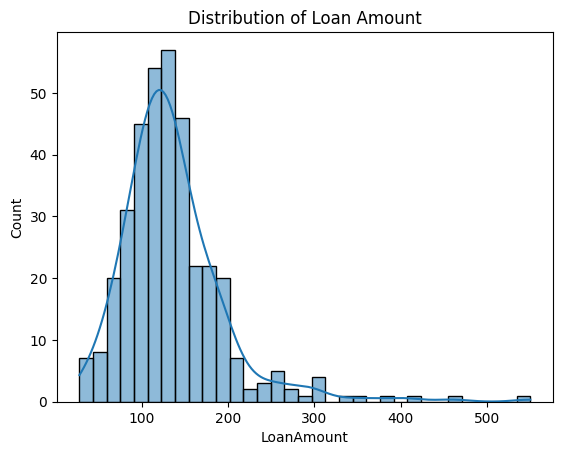

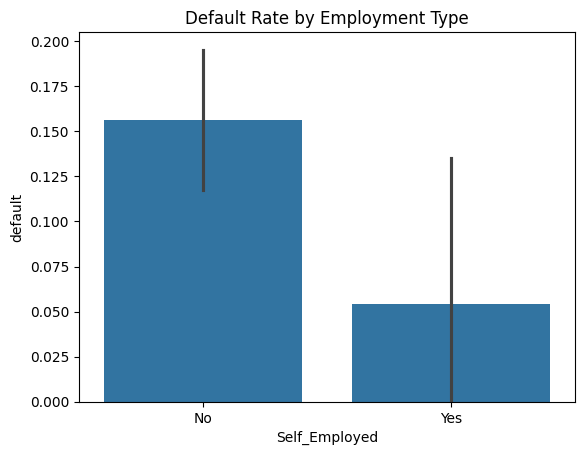

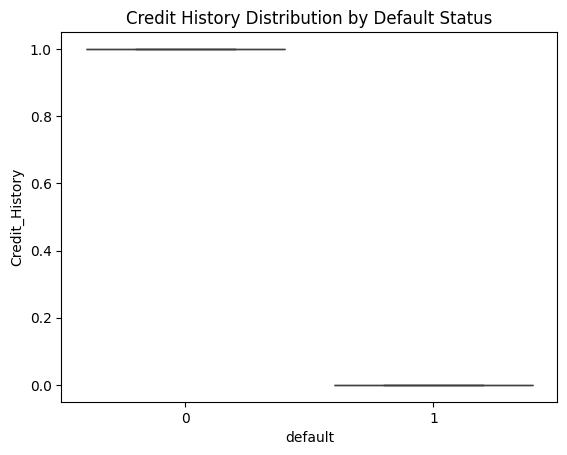

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Default rate
df['default'] = df['Credit_History'].apply(lambda x: 1 if x == 0 else 0)
default_rate = df['default'].mean()
print(f"\n Default rate: {default_rate:.2%}")

# Plot distribution of Loan Amount
sns.histplot(df['LoanAmount'], kde=True)
plt.title("Distribution of Loan Amount")
plt.show()

# Default rate by Employment Type
sns.barplot(data=df, x='Self_Employed', y='default')
plt.title("Default Rate by Employment Type")
plt.show()

# Credit_History vs default
sns.boxplot(data=df, x='default', y='Credit_History')
plt.title("Credit History Distribution by Default Status")
plt.show()


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import numpy as np

#  Define features and target
X = df.drop('default', axis=1)
y = df['default']

# Identify categorical and numerical columns
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(include=np.number).columns

#  Preprocessing pipeline: Impute + Scale + Encode
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

#  Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

print(" Data preprocessing setup complete.")
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


 Data preprocessing setup complete.
Train shape: (275, 14), Test shape: (92, 14)


In [9]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.pipeline import Pipeline

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)

    print(f"\n🔹 {model.__class__.__name__} Results:")
    print(f"Accuracy: {acc:.3f} | F1: {f1:.3f} | ROC AUC: {roc:.3f}")
    print(classification_report(y_test, y_pred))

    return acc, f1, roc


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

# Define models
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=150, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Train and compare
results = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    acc, f1, roc = evaluate_model(pipeline, X_train, X_test, y_train, y_test)
    results[name] = [acc, f1, roc]

# Show results
results_df = pd.DataFrame(results, index=['Accuracy', 'F1', 'ROC AUC']).T
results_df



🔹 Pipeline Results:
Accuracy: 0.989 | F1: 0.980 | ROC AUC: 0.993
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        68
           1       0.96      1.00      0.98        24

    accuracy                           0.99        92
   macro avg       0.98      0.99      0.99        92
weighted avg       0.99      0.99      0.99        92


🔹 Pipeline Results:
Accuracy: 0.978 | F1: 0.957 | ROC AUC: 0.958
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        68
           1       1.00      0.92      0.96        24

    accuracy                           0.98        92
   macro avg       0.99      0.96      0.97        92
weighted avg       0.98      0.98      0.98        92


🔹 Pipeline Results:
Accuracy: 1.000 | F1: 1.000 | ROC AUC: 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        68
           1       1.00      1.00      

,Accuracy,F1,ROC AUC
LogisticRegression,0.989130,0.979592,0.992647
RandomForest,0.978261,0.956522,0.958333
XGBoost,1.000000,1.000000,1.000000


In [11]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(categorical_cols)


['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']


In [12]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
df[categorical_cols] = encoder.fit_transform(df[categorical_cols])


In [13]:
# Create target column
df['default'] = df['Credit_History'].apply(lambda x: 1 if x == 0 else 0)

X = df.drop(columns=['Loan_ID', 'default'])
y = df['default']


In [14]:
best_model = Pipeline(steps=[('pre', preprocessor), ('model', models['XGBoost'])])
best_model.fit(X_train, y_train)
xgb_model = best_model.named_steps['model']


PermutationExplainer explainer: 93it [00:52,  1.56it/s]


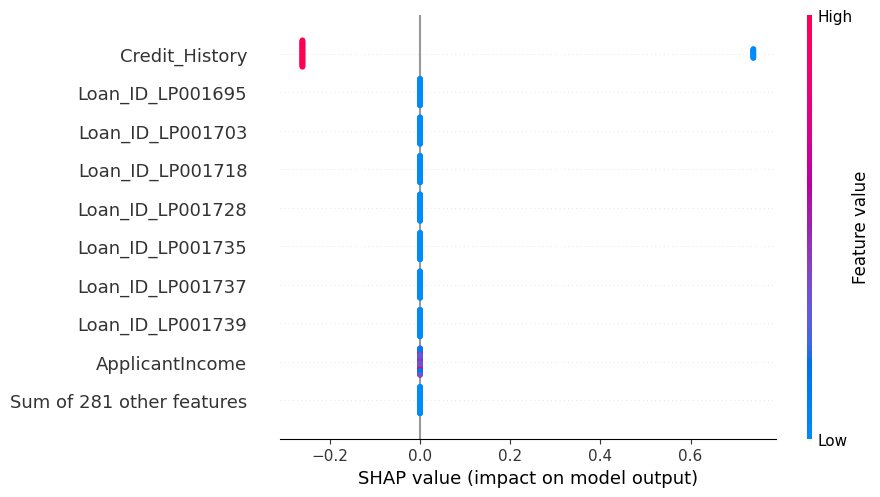

In [15]:
import shap
import numpy as np
from scipy.sparse import issparse

#  Ensure numeric dense input for SHAP
X_test_transformed = best_model.named_steps['pre'].transform(X_test)
if issparse(X_test_transformed):
    X_test_transformed = X_test_transformed.toarray()

#  Extract human-readable feature names
feature_names = best_model.named_steps['pre'].get_feature_names_out()
feature_names = [name.replace('num__', '').replace('cat__', '') for name in feature_names]

#  Create DataFrame for better SHAP visualization
X_test_shap = pd.DataFrame(X_test_transformed, columns=feature_names)

#  Create explainer
explainer = shap.Explainer(xgb_model.predict, X_test_shap)
shap_values = explainer(X_test_shap)

#  SHAP beeswarm plot with proper labels
shap.plots.beeswarm(shap_values, show=True)


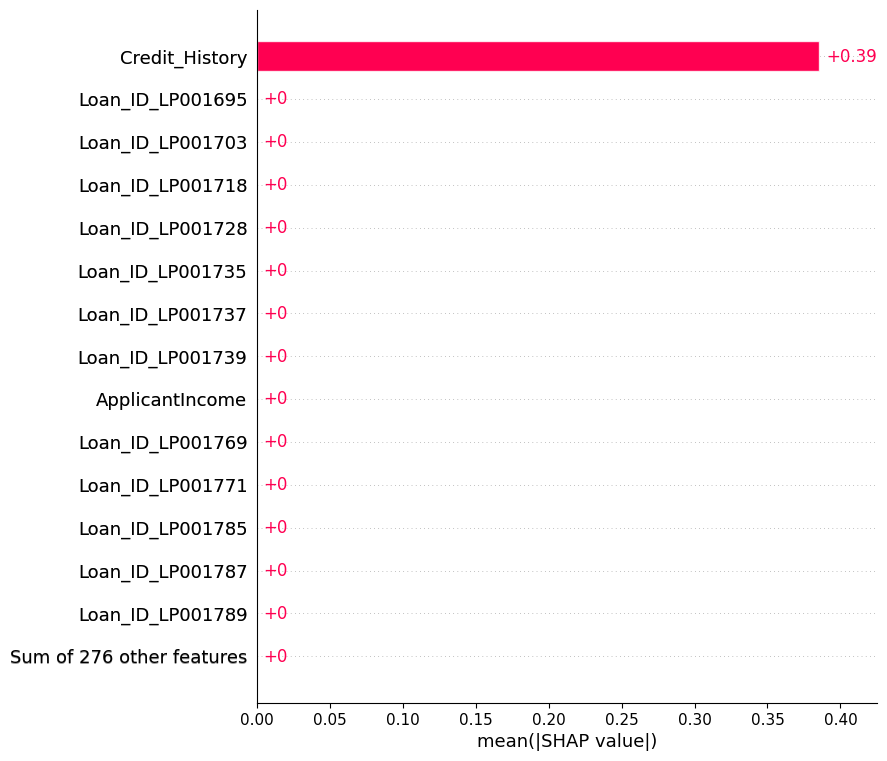

In [16]:
shap.plots.bar(shap_values, max_display=15)


In [17]:
joblib.dump(best_model, "loan_default_predictor.pkl")
print("Model saved as loan_default_predictor.pkl")


Model saved as loan_default_predictor.pkl


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, classification_report

# Enable inline plots
%matplotlib inline
sns.set(style="whitegrid")


In [21]:
# Evaluate all trained models on test data and store their performance
results = []

for name, model in models.items():
    clf = Pipeline(steps=[('pre', preprocessor), ('model', model)])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

    results.append({
        'Model': name,
        'Accuracy': acc,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    })

results_df = pd.DataFrame(results)
print("📊 Model Performance Summary:")
display(results_df)


📊 Model Performance Summary:


,Model,Accuracy,F1 Score,ROC AUC
0,LogisticRegression,0.989130,0.979592,0.9856
1,RandomForest,0.978261,0.956522,1.0000
2,XGBoost,1.000000,1.000000,1.0000


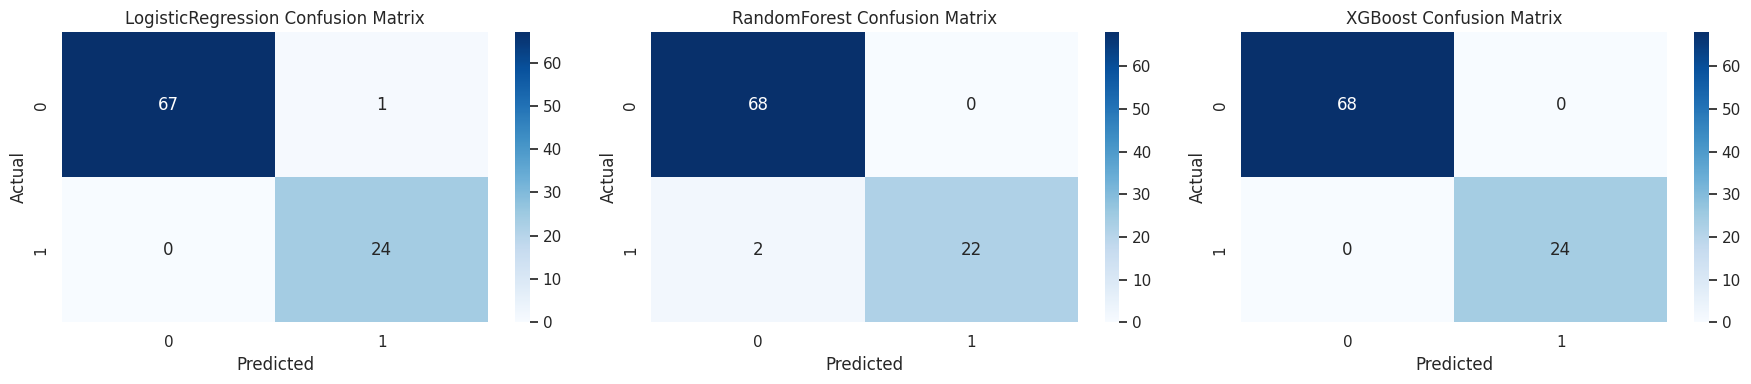

In [22]:
# Plot Confusion Matrices for all models
fig, axes = plt.subplots(1, len(models), figsize=(18, 4))

for ax, (name, model) in zip(axes, models.items()):
    clf = Pipeline(steps=[('pre', preprocessor), ('model', model)])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"{name} Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()


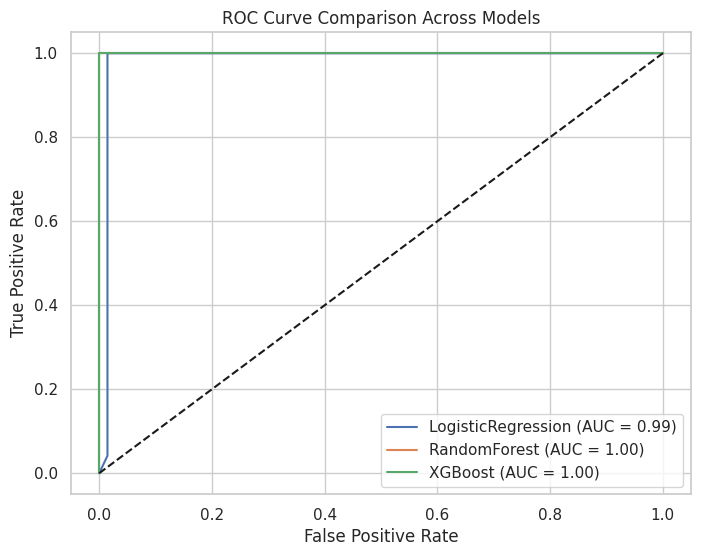

In [23]:
# Compare ROC Curves for all models
plt.figure(figsize=(8,6))

for name, model in models.items():
    clf = Pipeline(steps=[('pre', preprocessor), ('model', model)])
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve Comparison Across Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


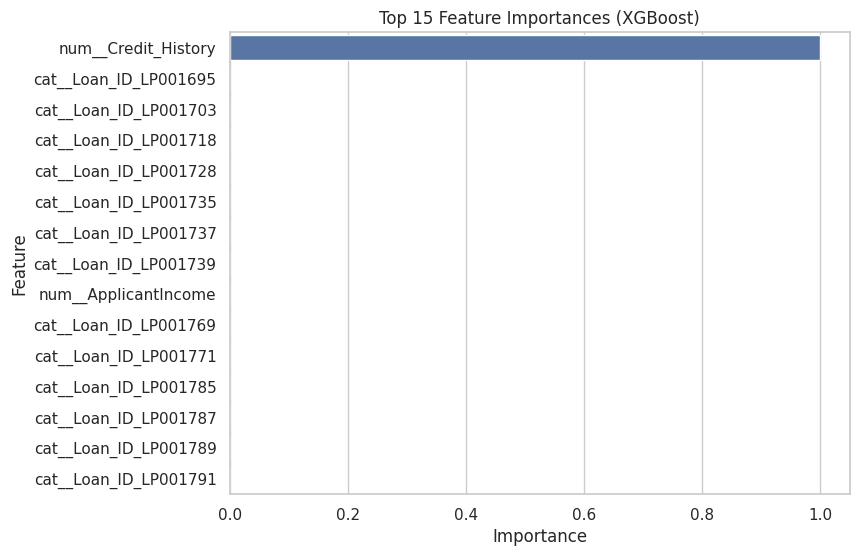

In [24]:
# Feature Importance from XGBoost
xgb_model = models['XGBoost']
best_model = Pipeline(steps=[('pre', preprocessor), ('model', xgb_model)])
best_model.fit(X_train, y_train)

xgb_final = best_model.named_steps['model']
X_train_transformed = best_model.named_steps['pre'].transform(X_train)
feature_names = best_model.named_steps['pre'].get_feature_names_out()

importances = xgb_final.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(8,6))
sns.barplot(x=importances[sorted_idx][:15], y=np.array(feature_names)[sorted_idx][:15])
plt.title("Top 15 Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


In [25]:
# Interactive comparison dashboard
fig = go.Figure()

fig.add_trace(go.Bar(
    x=results_df['Model'],
    y=results_df['Accuracy'],
    name='Accuracy'
))
fig.add_trace(go.Bar(
    x=results_df['Model'],
    y=results_df['F1 Score'],
    name='F1 Score'
))
fig.add_trace(go.Bar(
    x=results_df['Model'],
    y=results_df['ROC AUC'],
    name='ROC AUC'
))

fig.update_layout(
    title="Model Performance Dashboard",
    xaxis_title="Models",
    yaxis_title="Score",
    barmode='group',
    template='plotly_white',
    legend_title="Metrics"
)

fig.show()


In [26]:
# Export predictions and model results to CSV for Power BI
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

export_df = X_test.copy()
export_df['Actual'] = y_test.values
export_df['Predicted'] = y_pred
export_df['Probability'] = y_proba

export_df.to_csv('model_predictions.csv', index=False)
results_df.to_csv('model_metrics.csv', index=False)

print("Exported: model_predictions.csv and model_metrics.csv")


Exported: model_predictions.csv and model_metrics.csv


In [28]:
!pip install dash plotly dash-bootstrap-components


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.0/204.0 kB 17.1 MB/s eta 0:00:00


In [29]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# Combine all into one DataFrame
df_dash = X_test.copy()
df_dash['Actual'] = y_test
df_dash['Predicted'] = y_pred
df_dash['Probability'] = y_proba


In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_labels = ['No Default', 'Default']

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_df = pd.DataFrame({'FPR': fpr, 'TPR': tpr})


In [31]:
from dash import Dash, dcc, html
import dash_bootstrap_components as dbc
import plotly.express as px
import plotly.figure_factory as ff

# Initialize Dash app
app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Confusion Matrix heatmap
z = cm
x = cm_labels
y = cm_labels
conf_fig = ff.create_annotated_heatmap(
    z, x=x, y=y, colorscale='Blues', showscale=True
)
conf_fig.update_layout(title="Confusion Matrix", xaxis_title="Predicted", yaxis_title="Actual")

# ROC Curve
roc_fig = px.area(roc_df, x='FPR', y='TPR', title=f"ROC Curve (AUC = {roc_auc:.2f})")
roc_fig.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1)

# Probability Distribution
prob_fig = px.histogram(
    df_dash, x='Probability', color='Predicted', nbins=20,
    title="Prediction Probability Distribution", barmode='overlay'
)
prob_fig.update_traces(opacity=0.7)

# Feature Importance (if available)
try:
    feat_imp = pd.DataFrame({'Feature': X_test.columns, 'Importance': feature_importances})
    feat_fig = px.bar(feat_imp.sort_values('Importance', ascending=False),
                      x='Importance', y='Feature', title="Feature Importance", orientation='h')
except:
    feat_fig = px.bar(x=[0], y=["No importance data"], title="Feature Importance Not Available")

# Metrics Cards
metrics_cards = dbc.Row([
    dbc.Col(dbc.Card([dbc.CardBody([html.H5("Accuracy"), html.H3(f"{accuracy:.2f}")])]), width=2),
    dbc.Col(dbc.Card([dbc.CardBody([html.H5("Precision"), html.H3(f"{precision:.2f}")])]), width=2),
    dbc.Col(dbc.Card([dbc.CardBody([html.H5("Recall"), html.H3(f"{recall:.2f}")])]), width=2),
    dbc.Col(dbc.Card([dbc.CardBody([html.H5("F1 Score"), html.H3(f"{f1:.2f}")])]), width=2),
    dbc.Col(dbc.Card([dbc.CardBody([html.H5("ROC AUC"), html.H3(f"{roc_auc:.2f}")])]), width=2),
], justify='center')


In [33]:
app.layout = dbc.Container([
    html.H1("Loan Default Prediction Dashboard", style={'textAlign': 'center', 'marginTop': 20}),
    html.Hr(),
    metrics_cards,
    html.Br(),
    dbc.Row([
        dbc.Col(dcc.Graph(figure=conf_fig), md=6),
        dbc.Col(dcc.Graph(figure=roc_fig), md=6),
    ]),
    html.Br(),
    dbc.Row([
        dbc.Col(dcc.Graph(figure=prob_fig), md=6),
        dbc.Col(dcc.Graph(figure=feat_fig), md=6),
    ]),
], fluid=True)

app.run(mode='inline')


<IPython.core.display.Javascript object>